Dataset Preview:


User_ID  Age      Gender   Platform  Daily_Usage_Time (minutes)  \
0        1   25      Female  Instagram                         120   
1        2   30        Male    Twitter                          90   
2        3   22  Non-binary   Facebook                          60   
3        4   28      Female  Instagram                         200   
4        5   33        Male   LinkedIn                          45   

   Posts_Per_Day  Likes_Received_Per_Day  Comments_Received_Per_Day  \
0              3                      45                         10   
1              5                      20                         25   
2              2                      15                          5   
3              8                     100                         30   
4              1                       5                          2   

   Messages_Sent_Per_Day Dominant_Emotion  
0                     12        Happiness  
1                     30            Anger  
2                     20          Neutral  
3                     50          Anxiety  
4                     10          Boredom


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   User_ID                     1000 non-null   int64 
 1   Age                         1000 non-null   int64 
 2   Gender                      1000 non-null   object
 3   Platform                    1000 non-null   object
 4   Daily_Usage_Time (minutes)  1000 non-null   int64 
 5   Posts_Per_Day               1000 non-null   int64 
 6   Likes_Received_Per_Day      1000 non-null   int64 
 7   Comments_Received_Per_Day   1000 non-null   int64 
 8   Messages_Sent_Per_Day       1000 non-null   int64 
 9   Dominant_Emotion            1000 non-null   object
dtypes: int64(7), object(3)
memory usage: 78.3+ KB

Missing Values:
User_ID                       0
Age                           0
Gender                        0
Platform                      0
Daily_Usage

T-Test for Daily Usage Time by Gender:
T-Statistic: -5.889, P-Value: 0.000

Chi-Square Test for Platform and Dominant Emotion:
Chi-Square Statistic: 949.167, P-Value: 0.000

ANOVA for Daily Usage Time Across Dominant Emotions:
F-Statistic: 237.926, P-Value: 0.000

Spearman Correlation Between Engagement Score and Daily Usage Time:
Spearman Correlation: 0.910, P-Value: 0.000


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


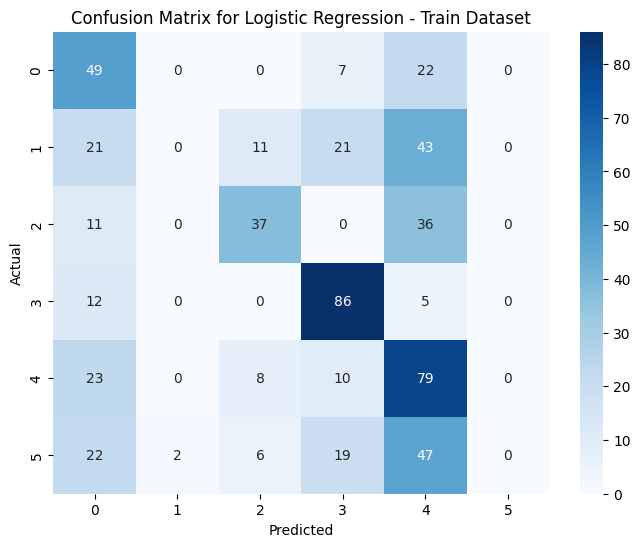

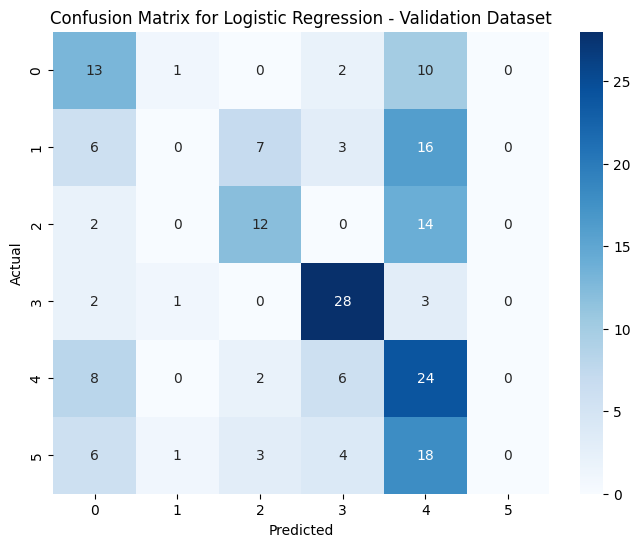

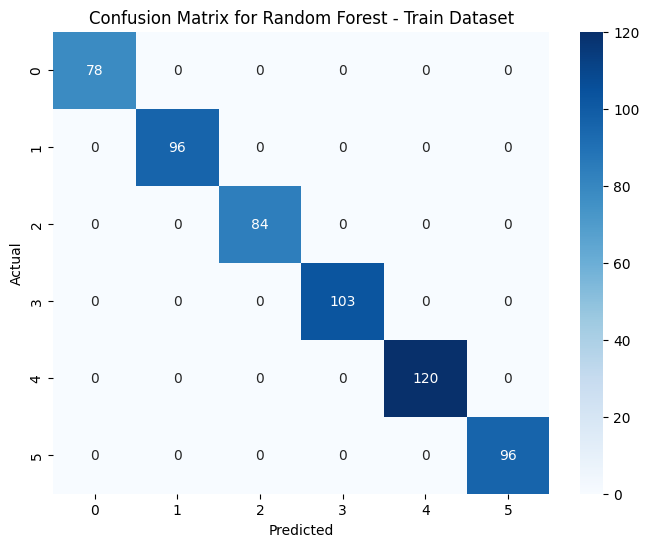

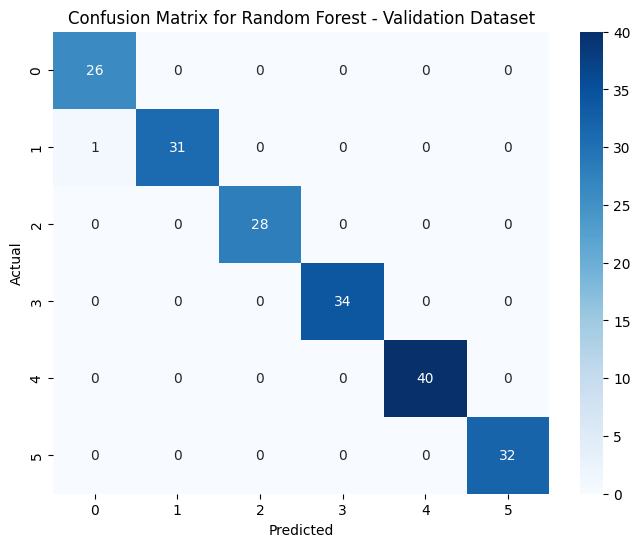

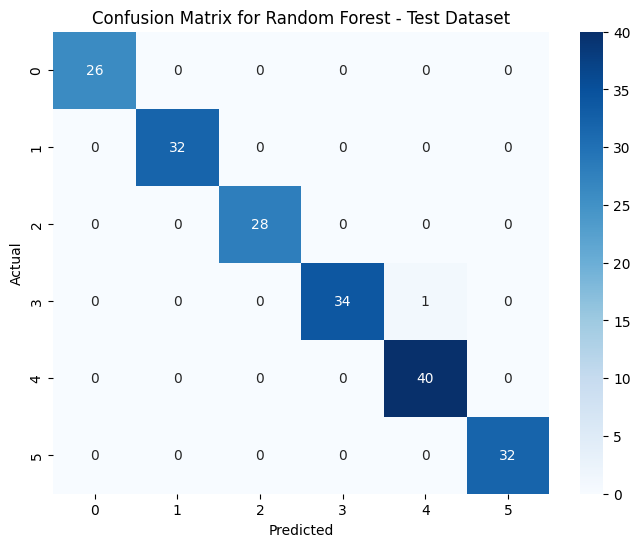

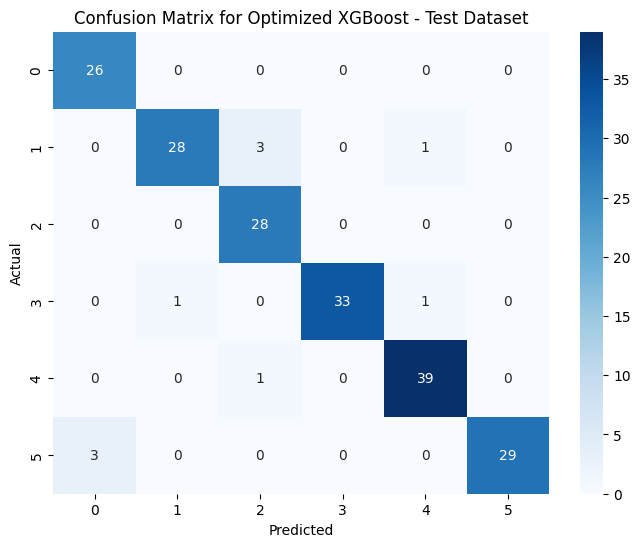


Model evaluation results saved to 'model_results.txt'.
Models saved successfully.


In [5]:
# # Social Media Emotion Prediction - Full Code

# ## Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import ttest_ind, chi2_contingency, f_oneway, spearmanr
import joblib

# ## Load the Dataset
file_path = r"C:\Users\HP\Desktop\damt project\test_data1.csv"
data = pd.read_csv(file_path)

# ## Explore the Dataset
print("Dataset Preview:")
display(data.head())

print("\nDataset Info:")
data.info()

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Target variable distribution
target_distribution = data['Dominant_Emotion'].value_counts()
print("\nTarget Variable Distribution:")
print(target_distribution)

# ## Data Preprocessing

# --- Handle Missing Values ---
numeric_features = ['Age', 'Daily_Usage_Time (minutes)', 'Posts_Per_Day',
                    'Likes_Received_Per_Day', 'Comments_Received_Per_Day', 
                    'Messages_Sent_Per_Day']
categorical_features = ['Gender', 'Platform']

# Fill missing numeric values with the mean
for col in numeric_features:
    data[col] = data[col].fillna(data[col].mean())
# Fill missing categorical values with the mode
for col in categorical_features:
    data[col] = data[col].fillna(data[col].mode()[0])

# --- Remove Outliers Using the IQR Method ---
for col in numeric_features:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[col] >= Q1 - 1.5 * IQR) & (data[col] <= Q3 + 1.5 * IQR)]

# --- Encode Categorical Features ---
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# --- Combine Highly Correlated Features ---
data['Engagement_Score'] = data['Likes_Received_Per_Day'] + data['Comments_Received_Per_Day']
data = data.drop(columns=['Likes_Received_Per_Day', 'Comments_Received_Per_Day'])

# --- Encode the Target Variable ---
target_col = 'Dominant_Emotion'
label_encoder_target = LabelEncoder()
data[target_col] = label_encoder_target.fit_transform(data[target_col])

# --- Standardize Numeric Features ---
scaler = StandardScaler()
numeric_features = ['Age', 'Daily_Usage_Time (minutes)', 'Posts_Per_Day',
                    'Messages_Sent_Per_Day', 'Engagement_Score']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# ## Train-Test Split
X = data.drop(columns=[target_col])
y = data[target_col]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

# ## Exploratory Data Analysis (EDA)

# --- Visualize Distributions of Numeric Features ---
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, start=1):
    plt.subplot(2, 3, i)
    sns.histplot(data[col], kde=True, bins=20, color='steelblue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# --- Boxplots for Numeric Features by Target ---
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, start=1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=data, x=target_col, y=col, hue=target_col, palette='Set2', dodge=False)
    plt.title(f"{col} Across {target_col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

# ## Statistical Analysis

# --- T-Test: Daily Usage Time by Gender ---
male_usage = data[data['Gender'] == 1]['Daily_Usage_Time (minutes)']
female_usage = data[data['Gender'] == 0]['Daily_Usage_Time (minutes)']
t_stat, p_value = ttest_ind(male_usage, female_usage, equal_var=False)
print("T-Test for Daily Usage Time by Gender:")
print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_value:.3f}")

# --- Chi-Square Test: Platform and Dominant Emotion ---
platform_emotion_table = pd.crosstab(data['Platform'], data['Dominant_Emotion'])
chi2, chi2_p, _, _ = chi2_contingency(platform_emotion_table)
print("\nChi-Square Test for Platform and Dominant Emotion:")
print(f"Chi-Square Statistic: {chi2:.3f}, P-Value: {chi2_p:.3f}")

# --- ANOVA: Daily Usage Time Across Dominant Emotions ---
emotion_groups = [data[data['Dominant_Emotion'] == emotion]['Daily_Usage_Time (minutes)'] for emotion in data['Dominant_Emotion'].unique()]
anova_stat, anova_p = f_oneway(*emotion_groups)
print("\nANOVA for Daily Usage Time Across Dominant Emotions:")
print(f"F-Statistic: {anova_stat:.3f}, P-Value: {anova_p:.3f}")

# --- Spearman Correlation ---
spearman_corr, spearman_p = spearmanr(data['Engagement_Score'], data['Daily_Usage_Time (minutes)'])
print("\nSpearman Correlation Between Engagement Score and Daily Usage Time:")
print(f"Spearman Correlation: {spearman_corr:.3f}, P-Value: {spearman_p:.3f}")

# ## Model Development

# --- Logistic Regression ---
log_reg = LogisticRegression(max_iter=1000, solver='saga', random_state=42)
log_reg.fit(X_train, y_train)

# --- Random Forest ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# --- Optimized XGBoost ---
xgb_optimized = XGBClassifier(eval_metric='mlogloss', n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
xgb_optimized.fit(X_train, y_train)

# ## Evaluation Function
def evaluate_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    results = {}
    for dataset, (X, y) in zip(['Train', 'Validation', 'Test'], [(X_train, y_train), (X_val, y_val), (X_test, y_test)]):
        predictions = model.predict(X)
        accuracy = accuracy_score(y, predictions)
        report = classification_report(y, predictions, zero_division=0, output_dict=True)
        conf_matrix = confusion_matrix(y, predictions)

        # Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.title(f"Confusion Matrix for {name} - {dataset} Dataset")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        results[dataset] = {
            'Accuracy': accuracy,
            'Classification Report': report,
            'Confusion Matrix': conf_matrix
        }
    return name, results

# ## Evaluate Models
evaluation_results = {}
for name, model in [('Logistic Regression', log_reg), ('Random Forest', rf), ('Optimized XGBoost', xgb_optimized)]:
    model_name, model_results = evaluate_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test)
    evaluation_results[model_name] = model_results

# Corrected section in the loop for saving model results
with open("model_results.txt", "w") as f:
    for model_name, model_results in evaluation_results.items():
        f.write(f"Model: {model_name}\n")
        for dataset, metrics in model_results.items():
            f.write(f"  {dataset} Dataset:\n")
            f.write(f"    Accuracy: {metrics['Accuracy']:.4f}\n")
            f.write("    Classification Report:\n")
            for label, scores in metrics['Classification Report'].items():
                if isinstance(scores, dict):  # Check to process only class-specific metrics
                    f.write(
                        f"      {label}: Precision: {scores['precision']:.4f}, "
                        f"Recall: {scores['recall']:.4f}, F1-Score: {scores['f1-score']:.4f}\n"
                    )
            f.write("    Confusion Matrix:\n")
            f.write(str(metrics['Confusion Matrix']) + "\n\n")
        f.write("\n")


print("\nModel evaluation results saved to 'model_results.txt'.")

# ## Save the Trained Models
joblib.dump(log_reg, "logistic_regression_model.joblib")
joblib.dump(rf, "random_forest_model.joblib")
joblib.dump(xgb_optimized, "xgboost_model.joblib")

print("Models saved successfully.")
